# PROJET 03: Concevez une application au service de la santé publique

- L'objectif de ce projet est de **concevoir une application au service de la santé publique**.



## Chargement des librairies

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn import neighbors
from sklearn.preprocessing import StandardScaler
import sklearn
from sklearn import decomposition, preprocessing
from wordcloud import WordCloud, STOPWORDS
import math
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from IPython.core.display import display, HTML
%matplotlib inline

## L'application 

L'idée d'application, avec test de faisabilité, portera sur une aide aux personnes atteintes de **L’homocystinurie**.



- **L'homocystinurie** (déficit en cystathione bêtasynthase) est une maladie génétique rare, grave, évolutive, associée à un risque de morbidité et de mortalité élevé. Elle est caractérisée par un retard mental, des atteintes oculaires (subluxation du cristallin, cataracte, etc.), squelettiques, psychiatriques, et par un risque majeur d'accidents vasculaires thromboemboliques artériels ou veineux.

- L'application sera dans un premier temps, un moteur de recommandation : à partir de la recherche d'un produit, la liste des produits les plus sains classés par le nombre de g de protéines le plus faible possible sera proposée, 

Les variables conservées sont donc :

pour établir le score :

- proteins_100g - g de protéines pour 100 g de produit
- nutriscore_score - nutri-score (-15 bien noté à 40 mal noté)

pour afficher des informations complémentaires :

- nutriscore_grade _fr 
- fat_100g - g de lipides pour 100 g de produit
- carbohydrates_100g - g de glucides pour 100 g de produit
- fiber_100g - g de fibres pour 100 g de produit
- image_url - photographie pour le reconnaître
- product_name - nom du produit (toutes les langues)
- sel - g de sel pour 100 g de produit
- energie - energie en kJoules pour 100 g de produit
Notes :

##  Chargement du jeu de données

In [18]:

#importation de la donnée
df_appli_clean= pd.read_csv('openfoodfacts_clean_appli.csv', sep='\t')


C:\Users\karim\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [19]:
df_appli_clean.head()

,code,image_url,product_name,pnns_groups_1,pnns_groups_2,main_category_fr,brands,additives_n,nutrition_grade_fr,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,nutrition-score-fr_100g,nb_ingredients_huile_palm,sel
0,5200016,http://fr.openfoodfacts.org/images/products/00...,lentilles vertes,Cereals and potatoes,Legumes,Aliments et boissons à base de végétaux,Bertrand Lejeune,0.0,A,1501.0,2.9,0.6,65.0,3.4,0.0,9.40,0.508772,0.0,0.4000
1,7730009,http://fr.openfoodfacts.org/images/products/00...,Biscuits sablés fourrage au cacao,Sugary snacks,Biscuits and cakes,Sablés,St Michel,3.0,C,1928.0,21.0,9.4,59.0,39.0,0.0,5.80,5.501934,1.0,0.2400
2,10090206,http://fr.openfoodfacts.org/images/products/00...,Thé de Noël aromatisé orange-cannelle,Beverages,Non-sugared beverages,Thés,Alice Délice,0.0,A,184.0,0.0,0.0,10.0,9.3,0.0,0.23,0.508772,0.0,0.0100
3,40608754,http://fr.openfoodfacts.org/images/products/00...,"Pepsi, Nouveau goût !",Beverages,Sweetened beverages,Sodas,Pepsi,2.0,E,177.0,0.0,0.0,10.4,10.4,0.0,0.00,13.000000,0.0,0.0254
4,87177756,http://fr.openfoodfacts.org/images/products/00...,7Up,Beverages,Sweetened beverages,Sodas aux fruits,"7Up,Pepsico",3.0,E,177.0,0.0,0.0,10.4,10.4,0.0,0.00,13.000000,0.0,0.1000


In [20]:
# Réduire notre data frame 
cols_a_garder = ['product_name', 'proteins_100g',
                 'nutrition-score-fr_100g', 'nutrition_grade_fr', 'fat_100g',
                 'carbohydrates_100g', 'fiber_100g', 'sel', 'energy_100g',
                 'image_url']
data_garde = df_appli_clean[cols_a_garder]
data_garde.head()

,product_name,proteins_100g,nutrition-score-fr_100g,nutrition_grade_fr,fat_100g,carbohydrates_100g,fiber_100g,sel,energy_100g,image_url
0,lentilles vertes,9.40,0.508772,A,2.9,65.0,0.0,0.4000,1501.0,http://fr.openfoodfacts.org/images/products/00...
1,Biscuits sablés fourrage au cacao,5.80,5.501934,C,21.0,59.0,0.0,0.2400,1928.0,http://fr.openfoodfacts.org/images/products/00...
2,Thé de Noël aromatisé orange-cannelle,0.23,0.508772,A,0.0,10.0,0.0,0.0100,184.0,http://fr.openfoodfacts.org/images/products/00...
3,"Pepsi, Nouveau goût !",0.00,13.000000,E,0.0,10.4,0.0,0.0254,177.0,http://fr.openfoodfacts.org/images/products/00...
4,7Up,0.00,13.000000,E,0.0,10.4,0.0,0.1000,177.0,http://fr.openfoodfacts.org/images/products/00...


In [21]:
# définir une data frame pour le scoring 

cols_score = ['proteins_100g', 'nutrition-score-fr_100g']
df_score = df_appli_clean[cols_score]

In [22]:
# fonction pour afficher le table de description statistique 

def stat_descriptives(dataframe, liste_variables):
    """
    Statistiques descriptives moyenne, mediane, variance, écart-type,
    skewness et kurtosis du dataframe transmis en paramètre
    ----------
    @param IN : dataframe : DataFrame, obligatoire
                liste_variables : colonne dont on veut voir les stat descr
    @param OUT : dataframe des statistiques descriptives
    """
    liste_mean = ['mean']
    liste_median = ['median']
    liste_var = ['var']
    liste_std = ['std']
    liste_skew = ['skew']
    liste_kurtosis = ['kurtosis']
    liste_mode = ['mode']
    liste_cols = ['Desc']
    liste_max = ['Max']
    liste_min = ['Min']

    for col in liste_variables:
        liste_mean.append(dataframe[col].mean())
        liste_median.append(dataframe[col].median())
        liste_var.append(dataframe[col].var(ddof=0))
        liste_std.append(dataframe[col].std(ddof=0))
        liste_skew.append(dataframe[col].skew())
        liste_kurtosis.append(dataframe[col].kurtosis())
        liste_cols.append(col)
        liste_mode.append(dataframe[col].mode().to_string())
        liste_min.append(dataframe[col].min())
        liste_max.append(dataframe[col].max())

    data_stats = [liste_mean, liste_median, liste_var, liste_std, liste_skew,
                  liste_kurtosis, liste_mode, liste_min, liste_max]
    df_stat = pd.DataFrame(data_stats, columns=liste_cols)

    return df_stat.style.hide_index()


In [23]:
# description statistique de DF 

stat_descriptives(df_score,cols_score)

Desc,proteins_100g,nutrition-score-fr_100g
mean,7.436662,7.671251
median,5.800000,5.000000
var,52.367700,60.619260
std,7.236553,7.785837
skew,1.302318,0.801746
kurtosis,1.782721,-0.554102
mode,0 0.0,0 0.508772
Min,0.000000,0.000000
Max,86.000000,40.000000


In [24]:
# Graph densité pour 1 ou plusieurs colonne d'un dataframe

def plot_graph(df_work):

    plt.figure(figsize=(10, 5))
    axes = plt.axes()

    label_patches = []
    colors = ['Blue', 'SeaGreen', 'Sienna', 'DodgerBlue', 'Purple']

    i = 0
    for col in df_work.columns:
        label = col
        sns.kdeplot(df_work[col], color=colors[i])
        label_patch = mpatches.Patch(
            color=colors[i],
            label=label)
        label_patches.append(label_patch)
        i += 1
    #plt.xlabel('')
    plt.legend(
        handles=label_patches,
        bbox_to_anchor=(
            1.05,
            1),
        loc=2,
        borderaxespad=0.,
        facecolor='white')
    plt.grid(False)
    axes.set_facecolor('white')

    plt.show()



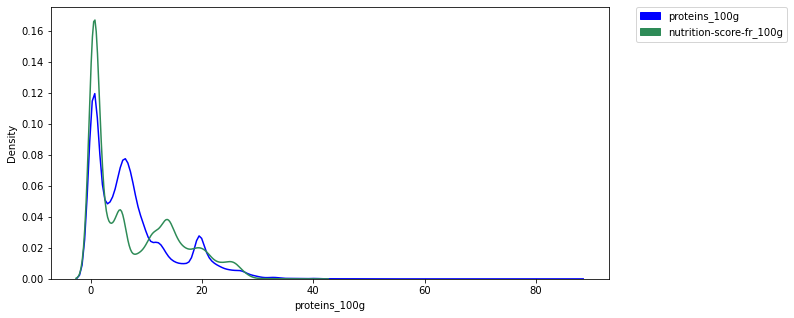

In [25]:
plot_graph(df_score)

- Pour mettre au même niveaux les données on vas appliquer une methode pour mettre en echelles ces derniers, 

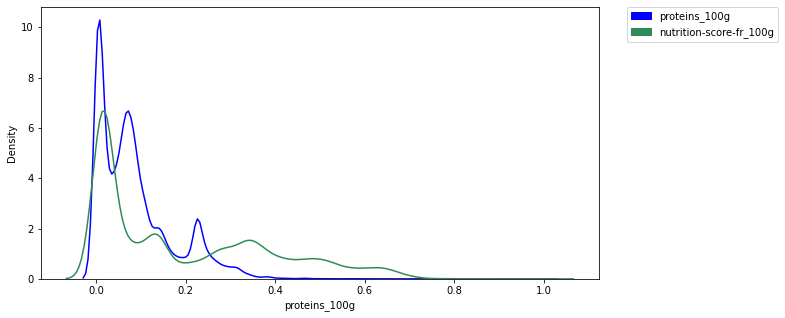

In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler_MinMax = MinMaxScaler()
scaled_df_MinMax = scaler_MinMax.fit_transform(df_score)
scaled_df_MinMax = pd.DataFrame(scaled_df_MinMax, columns=cols_score)
plot_graph(scaled_df_MinMax)

In [26]:
# description statistique de DF 
scaled_df_MinMax=df_score.copy()
stat_descriptives(scaled_df_MinMax,cols_score)

Desc,proteins_100g,nutrition-score-fr_100g
mean,7.436662,7.671251
median,5.800000,5.000000
var,52.367700,60.619260
std,7.236553,7.785837
skew,1.302318,0.801746
kurtosis,1.782721,-0.554102
mode,0 0.0,0 0.508772
Min,0.000000,0.000000
Max,86.000000,40.000000


### Scoring
Pondération

In [27]:

df_score = df_appli_clean.copy()
df_score['Score'] = [(row[0] * 10 + row[1] * 2 ) for row in zip(
    scaled_df_MinMax['proteins_100g'], scaled_df_MinMax['nutrition-score-fr_100g'])]

In [28]:
#Transforms text to feature vectors that can be used as input to estimator
from sklearn.feature_extraction.text import TfidfVectorizer
count = TfidfVectorizer()
count.fit(df_score['product_name'])
count_matrix = count.transform(df_score['product_name'])

In [29]:
# Ajout variables : lipides - Glucides - Sucre - Sel - Additif - huile palme
df_score['L_G_Su_Se_Ad_Hp'] = [(str(row[0]) + '-' + str(row[1]) + '-' + str(row[2]) + '-' + str(row[3]) + '-' + str(row[4]) + '-' + str(row[5])) for row in zip(
    df_score['fat_100g'], df_score['carbohydrates_100g'], df_score['sugars_100g'], df_score['sel'], df_score['additives_n'], df_score['nb_ingredients_huile_palm'])]

In [30]:
df_comparaison = df_score.filter(items=['product_name', 'image_url', 'proteins_100g','nutrition_grade_fr'
                                        , 'nutrition-score-fr_100g', 'brands', 'L_G_Su_Se_Ad_Hp', 'Score'])
df_comparaison.set_index('product_name')

,image_url,proteins_100g,nutrition_grade_fr,nutrition-score-fr_100g,brands,L_G_Su_Se_Ad_Hp,Score
product_name,,,,,,,
lentilles vertes,http://fr.openfoodfacts.org/images/products/00...,9.40,A,0.508772,Bertrand Lejeune,2.9-65.0-3.4-0.4-0.0-0.0,95.017544
Biscuits sablés fourrage au cacao,http://fr.openfoodfacts.org/images/products/00...,5.80,C,5.501934,St Michel,21.0-59.0-39.0-0.24-3.0-1.0,69.003867
Thé de Noël aromatisé orange-cannelle,http://fr.openfoodfacts.org/images/products/00...,0.23,A,0.508772,Alice Délice,0.0-10.0-9.3-0.01-0.0-0.0,3.317544
"Pepsi, Nouveau goût !",http://fr.openfoodfacts.org/images/products/00...,0.00,E,13.000000,Pepsi,0.0-10.4-10.4-0.0254-2.0-0.0,26.000000
7Up,http://fr.openfoodfacts.org/images/products/00...,0.00,E,13.000000,"7Up,Pepsico",0.0-10.4-10.4-0.1-3.0-0.0,26.000000
...,...,...,...,...,...,...,...
Les Belles Tranches Bacon fumé,http://fr.openfoodfacts.org/images/products/98...,19.45,B,0.946674,Justin Bridou,11.0-0.9-0.6-1.8-0.0-0.0,196.393348
Tartines craquantes bio au sarrasin,http://fr.openfoodfacts.org/images/products/98...,13.00,A,0.508772,Le Pain des fleurs,2.8-74.8-2.6-0.68-0.0-0.0,131.017544
Miel de Camargue,http://fr.openfoodfacts.org/images/products/99...,5.80,C,5.501934,L. Boulaire,21.0-59.0-39.0-0.24-0.0-0.0,69.003867


In [31]:
cols_affich = ['image_url', 'proteins_100g', 'nutrition_grade_fr', 'nutrition-score-fr_100g', 'brands', 'L_G_Su_Se_Ad_Hp']


In [34]:
def path_to_image_photo_html(path):
    return '<img src="' + path + ' " width="100">'

In [35]:
def rech_produits(prod_saisi, results_number=10):
    if (type(prod_saisi) != str) or (len(prod_saisi) <= 2):
        return print('Le produit saisi doit être un texte contenant plus de 2 caractères')

    results = []
    
    # Vectorisation
    vector_prod = count.transform([prod_saisi])
    print("Produits recommandés : ")
    results.append(cosine_similarity(vector_prod, count_matrix))
    results = pd.Series(results).sort_values(ascending=False)
    elem_list = []
    for i in results:
        for elem in i[0]:
            elem_list.append(elem)
        # Ajout des similarités
        df_comparaison['Similarité'] = elem_list
        # Récupération des index des élements
        liste_produits = pd.Series(elem_list).sort_values(ascending=False)
        liste_produits = liste_produits.iloc[0:results_number].index
        # Récupération des produits correspondant aux index du df_comparaison
        top_produits = df_comparaison.iloc[liste_produits]
        top_produits.set_index('product_name', inplace=True)
        top_produits = top_produits.sort_values(by='Score')
        if max(top_produits['Similarité']) == 0.00000:
            return print('Aucun produit trouvé')

        df_prod = top_produits[cols_affich]
    # Affichage des images : photos, nutri-score
    pd.set_option('display.max_colwidth', None)
    print('Remarque : L_G_Su_Se_Ad_Hp : lipides - Glucides - Sucre - Sel - Additif - huile palme')

    return display(HTML(df_prod.to_html(escape=False, formatters=dict(image_url=path_to_image_photo_html))))

- **test de moteur de recherche**

In [37]:
# test moteur - 
produit = input(str('Quel est le produit recherché ? : '))
rech_produits(produit)

Quel est le produit recherché ? : yaourt
Produits recommandés : 
Remarque : L_G_Su_Se_Ad_Hp : lipides - Glucides - Sucre - Sel - Additif - huile palme


,image_url,proteins_100g,nutrition_grade_fr,nutrition-score-fr_100g,brands,L_G_Su_Se_Ad_Hp
product_name,,,,,,
Yaourt nature,,3.0,C,3.000000,Delisse,12.0-4.8-11.0-0.103-0.0-0.0
Yaourt nature,NaN,3.8,A,0.508772,Leader Price,1.1-5.0-4.7-0.16-0.0-0.0
Yaourt nature,,3.8,A,0.508772,Bonneterre,3.5-5.9-4.7-0.16-0.0-0.0
Yaourt Nature,NaN,3.9,A,0.508772,Dia,1.0-5.0-4.5-0.1016-0.0-0.0
Yaourt Nature,,4.0,A,0.508772,Auchan,1.4-4.2-4.2-0.127-0.0-0.0
Yaourt nature,,4.0,A,0.508772,Carrefour,1.0-4.3-4.3-0.127-0.0-0.0
Yaourt,,4.6,B,0.946674,Vrai,12.0-4.8-4.7-0.16-0.0-0.0
Yaourt Nature,,4.6,B,0.946674,Les Yaourts de Sigy,12.0-4.8-4.7-0.16-0.0-0.0
Yaourt Nature 0%,,4.7,A,0.508772,Malo,0.5-6.7-6.7-0.14-0.0-0.0


In [36]:
# test moteur - 
produit = input(str('Quel est le produit recherché ? : '))
rech_produits(produit)

Quel est le produit recherché ? : chocolat
Produits recommandés : 
Remarque : L_G_Su_Se_Ad_Hp : lipides - Glucides - Sucre - Sel - Additif - huile palme


,image_url,proteins_100g,nutrition_grade_fr,nutrition-score-fr_100g,brands,L_G_Su_Se_Ad_Hp
product_name,,,,,,
Chocolat,,5.8,C,5.501934,Les délices de la Bouriane,21.0-59.0-39.0-0.24-1.0-0.0
Chocolat,,5.8,C,5.501934,BN,21.0-59.0-39.0-0.24-0.0-0.0
Chocolat,,3.2,E,20.000000,Adélie,13.1-39.3-28.9-0.27-6.0-2.0
Chocolat,,4.1,E,20.866563,Bien vu,23.0-70.0-39.0-0.24-2.0-0.0
Chocolat,,5.4,E,21.000000,Tous les jours,23.0-61.0-59.0-0.01-2.0-0.0
Chocolat,,5.5,E,21.000000,Eco+,23.0-61.0-59.0-0.00762-2.0-0.0
Chocolat,,5.4,E,25.000000,Pouce,23.0-59.0-59.0-0.02-2.0-0.0
Chocolat,,5.4,E,25.000000,Top Budget,23.0-59.0-59.0-0.02-2.0-0.0
Chocolat,,9.0,D,11.000000,Carrefour,43.0-34.0-0.5-0.02-0.0-0.0


In [185]:
# test du pré-moteur - 1 caractère saisi, nombre entier
produit = input(str('Quel est leproduit recherché ? : '))
rech_produits(produit)

Quel est leproduit recherché ? : fromage
Produits recommandés : 
Remarque : L_G_Su_Se_Ad_Hp : lipides - Glucides - Sucre - Sel - Additif - huile palme


,image_url,proteins_100g,nutrition_grade_fr,nutrition-score-fr_100g,brands,L_G_Su_Se_Ad_Hp
product_name,,,,,,
Fromage,,4.6,B,0.946674,"Marcillat,Moulin à vent",12.0-4.8-4.7-0.16-0.0-0.0
Fromage blanc,,6.4,A,0.508772,Top Budget,2.8-5.1-5.1-0.09-0.0-0.0
Fromage blanc,,6.6,B,2.000000,Carrefour,7.9-4.1-3.6-0.1-0.0-0.0
Fromage blanc 0%,,7.3,A,0.508772,Auchan,0.1-4.5-4.5-0.1-0.0-0.0
Fromage blanc,,7.6,A,0.508772,Auchan,3.2-3.2-3.2-0.1524-0.0-0.0
Fromage Blanc 0%,,8.0,A,0.508772,"Carrefour Discount,Carrefour",0.0-4.2-4.7-0.1016-0.0-0.0
Saveur Fromage,NaN,6.2,D,11.000000,Lay's,32.0-52.0-3.0-1.9-2.0-1.0
Jambon Fromage,,10.5,B,2.000000,Cora,5.7-32.0-2.2-1.52-8.0-0.0
Saveur Fromage,,6.3,D,12.000000,Lay's,33.0-82.0-3.0-1.9-2.0-1.0
